In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize
from nltk import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

In [3]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/jlima/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jlima/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jlima/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2022-06-08 12:48:34--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4,8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4,85M  1,76MB/s    in 2,8s    

2022-06-08 12:48:38 (1,76 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [6]:
df = pd.read_csv('bbc_text_cls.csv')

In [7]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [8]:
inputs = df['text']
labels = df['labels']

<AxesSubplot:>

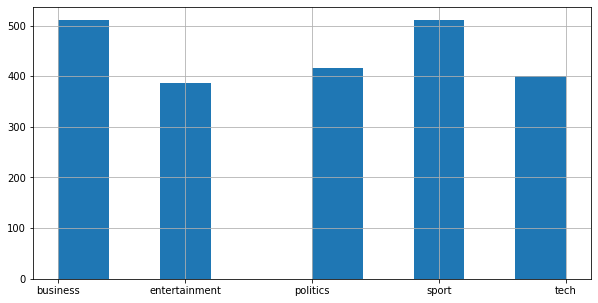

In [9]:
labels.hist(figsize=(10, 5))

In [10]:
inputs_train, inputs_test, y_train, y_test = train_test_split(inputs, labels, random_state = 123)

In [11]:
vectorizer = CountVectorizer()

In [18]:
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

In [19]:
Xtrain

<1668x26287 sparse matrix of type '<class 'numpy.int64'>'
	with 337411 stored elements in Compressed Sparse Row format>

In [20]:
(Xtrain != 0).sum()

337411

In [21]:
# what percentage of values are non-zero?
(Xtrain != 0).sum() / np.prod(Xtrain.shape)

0.007695239935415004

In [22]:
model = MultinomialNB()
model.fit(Xtrain, y_train)
print('train score: ', model.score(Xtrain, y_train))
print('test score: ', model.score(Xtest, y_test))

train score:  0.9922062350119905
test score:  0.9712746858168761


In [23]:
# with stopwords

vectorizer = CountVectorizer(stop_words = 'english')
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, y_train)

print('train score: ', model.score(Xtrain, y_train))
print('test score: ', model.score(Xtest, y_test))

train score:  0.9928057553956835
test score:  0.9766606822262118


In [24]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [27]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words_and_tags = nltk.pos_tag(tokens)
        return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) \
               for word, tag in words_and_tags]

In [34]:
%%time
# with lemmatization

vectorizer = CountVectorizer(tokenizer = LemmaTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, y_train)

print('train score: ', model.score(Xtrain, y_train))
print('test score: ', model.score(Xtest, y_test))

train score:  0.9922062350119905
test score:  0.9676840215439856
CPU times: user 1min 9s, sys: 187 ms, total: 1min 10s
Wall time: 1min 13s


In [31]:
class StemTokenizer:
    def __init__(self):
        self.porter = PorterStemmer()
        
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        return [self.porter.stem(t) for t in tokens]

In [33]:
%%time
# with stemming

vectorizer = CountVectorizer(tokenizer = StemTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, y_train)

print('train score: ', model.score(Xtrain, y_train))
print('test score: ', model.score(Xtest, y_test))

train score:  0.9892086330935251
test score:  0.9694793536804309
CPU times: user 23.2 s, sys: 4.24 ms, total: 23.2 s
Wall time: 23.3 s


In [35]:
def simple_tokenizer(s):
    return s.split()

In [38]:
%%time
# with split tokenizer

vectorizer = CountVectorizer(tokenizer = simple_tokenizer)
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, y_train)

print('train score: ', model.score(Xtrain, y_train))
print('test score: ', model.score(Xtest, y_test))

train score:  0.9952038369304557
test score:  0.9712746858168761
CPU times: user 898 ms, sys: 35.9 ms, total: 934 ms
Wall time: 1.03 s


In [ ]:
# what is the vector dimensionality in each case?
# Compare them and consider why the are larger / smaller